In [ ]:
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten,UpSampling2D
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import load_model
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import argparse
from PIL import Image

In [ ]:
def build_generator(inputs, image_size):
    image_resize = image_size // 4
    kernel_size = 5

    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=100))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2DTranspose(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2DTranspose(1, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(100,))
    img = model(noise)

    return Model(noise, img)

In [ ]:
def build_discriminator(inputs):
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    for filters in layer_filters:
            if filters == layer_filters[-1]:
                strides = 1
            else:
                strides = 2
    x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model(inputs, x, name='discriminator')

    discriminator.summary()
    return discriminator   

In [ ]:
def train(models, x_train, params):
    dis_loss = []
    adver_loss = []
    dis_acc = []
    adver_acc = []
    generator, discriminator, adversarial = models
    batch_size, latent_size, train_steps, model_name, image_size = params
    save_interval = 2
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    plot_input = np.random.uniform(-1.0, 1.0, size=[25, latent_size])
    train_size = x_train.shape[0]
    for i in range(train_steps):
        #noise_to_d = np.random.normal(0, 2/(i+1), (batch_size, image_size, image_size, 1))
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes] #+ noise_to_d
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        fake_images = generator.predict(noise)
        
        x = np.concatenate((real_images, fake_images))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        #one-sided label smoothing
        y[0:batch_size, :] = 0.9
        
        loss, acc = discriminator.train_on_batch(x, y)
        dis_loss.append(loss)
        dis_acc.append(acc)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        y = np.ones([batch_size, 1])
        
        loss, acc = adversarial.train_on_batch(noise, y)
        adver_loss.append(loss)
        adver_acc.append(acc)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        
        if (i + 1) % save_interval == 0:
            plot_images(generator,noise_input=plot_input,show=False,step=(i + 1),model_name=model_name)
            
    #generator.save(model_name + ".h5")  
    plot_loss(dis_loss,adver_loss)
    plot_accuracy(dis_acc,adver_acc)


In [ ]:
from google.colab import files
def plot_images(generator,noise_input,show=False,step=0,model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict(noise_input)
    plt.figure(figsize=(5, 5))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')

    #plt.savefig(filename)
    plt.show()        
        

In [ ]:
def build_and_train_models():
    (x_train, _), (_, _) = fashion_mnist.load_data()

    image_size = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

    #x_train = x_train.astype('float32') / 255

    model_name = "dcgan_fashiomnist"
    latent_size = 100
    batch_size = 64
    train_steps = 10
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)

    inputs = Input(shape=(image_size, image_size, 1), name='discriminator_input')
    discriminator = build_discriminator(inputs)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',
                              optimizer=optimizer,
                              metrics=['accuracy'])
    discriminator.summary()

    input_shape = (latent_size,)
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, image_size)
    generator.summary()

    optimizer = RMSprop(lr=lr * 0.5, decay=decay * 0.5)
    
    noise = np.random.normal(0, 5/train_steps, (batch_size, image_size))

    discriminator.trainable = False

    adversarial = Model(inputs, 
                           discriminator(generator(inputs)),
                            name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
    adversarial.summary()


    models = (generator, discriminator, adversarial)
    params = (batch_size, latent_size, train_steps, model_name, image_size)
    train(models, x_train, params)    

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (InputL  [(None, 28, 28, 1)]      0         
 ayer)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 256)       6656      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 flatten_3 (Flatten)         (None, 200704)            0         
                                                                 
 dense_6 (Dense)             (None, 1)                 200705    
                                                                 
 activation_12 (Activation)  (None, 1)                 0         
                                                     

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Model: "dcgan_fashiomnist"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_input (InputLayer)        [(None, 100)]             0         
                                                                 
 model_3 (Functional)        (None, 28, 28, 1)         856193    
                                                                 
 discriminator (Functional)  (None, 1)                 207361    
                                                                 
Total params: 1,063,554
Trainable params: 855,809
Non-trainable params: 207,745
_________________________________________________________________
0: [discriminator loss: 3.870253, acc: 0.390625] [adversarial loss: 0.182048, acc: 1.000000]
1: [discriminator loss: 19.020679, acc: 0.000000] [adversarial loss: 0.184141, acc: 1.000000]


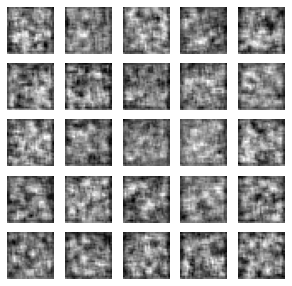

2: [discriminator loss: 16.173494, acc: 0.023438] [adversarial loss: 0.227097, acc: 1.000000]
3: [discriminator loss: 11.989545, acc: 0.500000] [adversarial loss: 0.288540, acc: 1.000000]


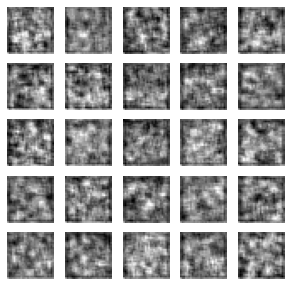

4: [discriminator loss: 9.460377, acc: 0.500000] [adversarial loss: 0.378399, acc: 1.000000]
5: [discriminator loss: 5.339724, acc: 0.500000] [adversarial loss: 0.491963, acc: 1.000000]


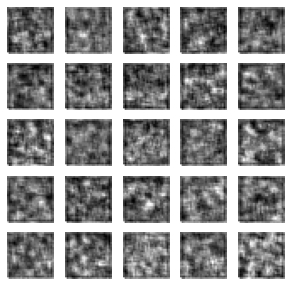

6: [discriminator loss: 3.529536, acc: 0.500000] [adversarial loss: 0.690732, acc: 0.531250]
7: [discriminator loss: 8.135632, acc: 0.500000] [adversarial loss: 0.244759, acc: 1.000000]


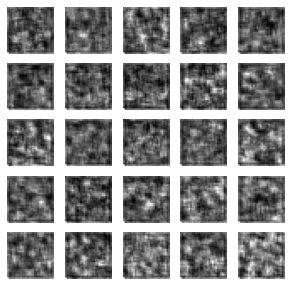

8: [discriminator loss: 9.222459, acc: 0.500000] [adversarial loss: 0.293936, acc: 1.000000]
9: [discriminator loss: 8.035870, acc: 0.500000] [adversarial loss: 0.364239, acc: 1.000000]


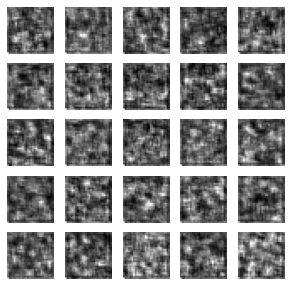

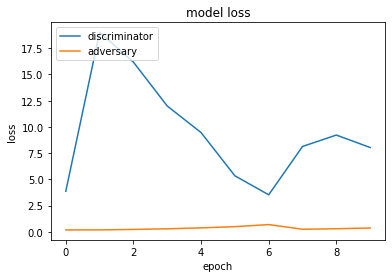

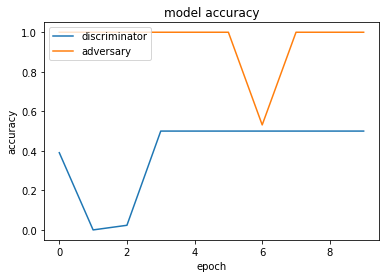

In [ ]:
build_and_train_models() 

In [ ]:
#loss history for train
def plot_loss(dis_loss,gen_loss):
  plt.plot(dis_loss)
  plt.plot(gen_loss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()

In [ ]:
#accuracy plot for train
def plot_accuracy(dis_acc,gen_acc):
  plt.plot(dis_acc)
  plt.plot(gen_acc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['discriminator', 'adversary'], loc='upper left')
  plt.show()